# Running with 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import yaml
import pickle
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print('GPU devices available:', tf.config.list_physical_devices('GPU'))

from scipy import io
import braincoder
from braincoder.utils.visualize import *
import prfpy_csenf

from os.path import join as opj
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel
from braincoder.stimuli import ContrastSensitivityStimulus
from braincoder.bprf_mcmc import BPRF
from braincoder.optimize import ParameterFitter
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-02-10 11:30:04.565561: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 11:30:04.565819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 11:30:04.565835: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 11:30:04.578789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/home/daghlian/.conda/envs/braincoder_b/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sim_file = './output_CS_amb_LE1'
with open(opj(sim_file,'ground_truth.pkl'), 'rb') as file:
    gt = pickle.load(file)
    bounds = gt['bounds']
    data = gt['data']
with open(opj(sim_file,'cfitter.pkl'), 'rb') as file:
    cf = pickle.load(file)
    cfitter = cf['cfitter']
    cfit_time = cf['cfit_time']

model = cfitter.model    
refined_pars = cfitter.estimated_parameters
bounds['aulcsf'] = [0, 150]
refined_pars['aulcsf'] = model.quick_aulcsf(refined_pars)
refined_pars['rsq'] = cfitter.get_rsq(parameters=refined_pars)
# with open(opj(sim_file,'bfitter.pkl'), 'rb') as file:
#     bf = pickle.load(file)
#     bfitter = bf['bfitter']
#     for i in range(bfitter.n_voxels):
#         bfitter.mcmc_sampler[i]['aulcsf'] = model.quick_aulcsf(
#             parameters = bfitter.mcmc_sampler[i]
#         )    
#     bfit_time = bf['bfit_time']
# print(cfit_time)
# print(bfit_time)

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/braincoder_bprf/braincoder/models.py:2111: RuntimeWarning: divide by zero encountered in log10
  logcsf_curve = np.log10(csf_curve)


In [51]:
from dag_prf_utils.mesh_maker import *
fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer'
sub = 'sub-02'
mm = GenMeshMaker(
    sub='sub-02',
    fs_dir=fs_dir,
)

No plotly
no dash..
No cortex
Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...


Error: Numerical issue.


Nans present: 0.0
Failed to flatten, retrying with morph 0
Nans present: 0.0
Successful flatten with morph=1
Here it looks like this...


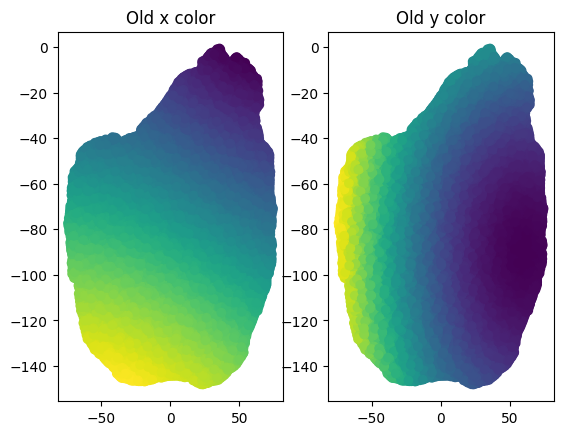

Faces with missing vx: 240946
Faces with long edges: 865
0.16564166493524482
Nans present: 0.0
Successful flatten with morph=0
Here it looks like this...


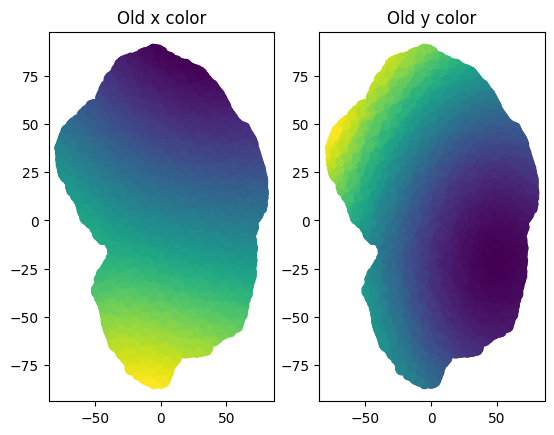

Faces with missing vx: 243750
Faces with long edges: 1107
0.16869590128711454


In [74]:
centre_bool = dag_load_roi(sub=sub, fs_dir=fs_dir, roi='b14_', combine_matches=True)
mm.make_flat_map(
    centre_bool=centre_bool, method='igl', morph=10
)

{'cmap': 'viridis', 'vmin': 0, 'vmax': 6}


{'cmap': 'viridis', 'vmin': 0, 'vmax': 6}

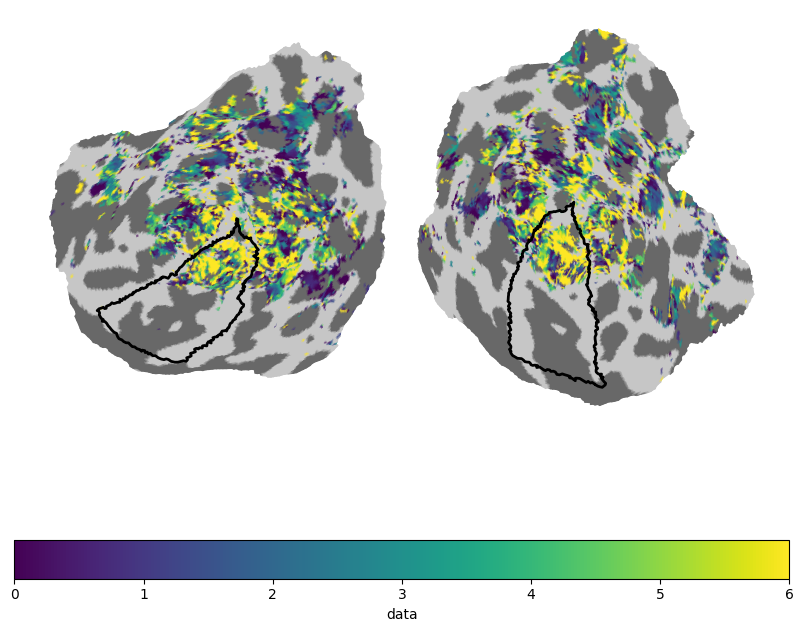

In [83]:
mm.flat_mpl(
    data=refined_pars['SFp'].to_numpy(),    
    data_mask = refined_pars['rsq']>0.1,  
    vmin=0, vmax=6, 
    roi_list=['b14_V1'])
# mm.mesh_info['flat']

In [ ]:
a

In [47]:
mm.mesh_info['flat']''

KeyError: 'rh'

In [23]:
mm.get_lr_roi_list('V1', roi_list_excl='')

{'lh': ['/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/label/b14_label/lh.b14_V1.label',
  '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/label/lh.V1_exvivo.label'],
 'rh': ['/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/label/b14_label/rh.b14_V1.label',
  '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/label/rh.V1_exvivo.label']}

In [17]:
mm.mesh_info.keys()

dict_keys(['inflated', 'sphere', 'pial', 'flat'])

(214, 1000)

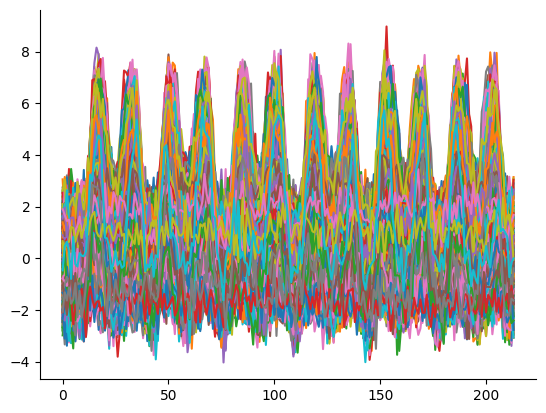

In [31]:
data.plot(legend=False)
sns.despine()
data.shape

In [ ]:
plt.plot(bfitter.mcmc_stats['log_prob'])

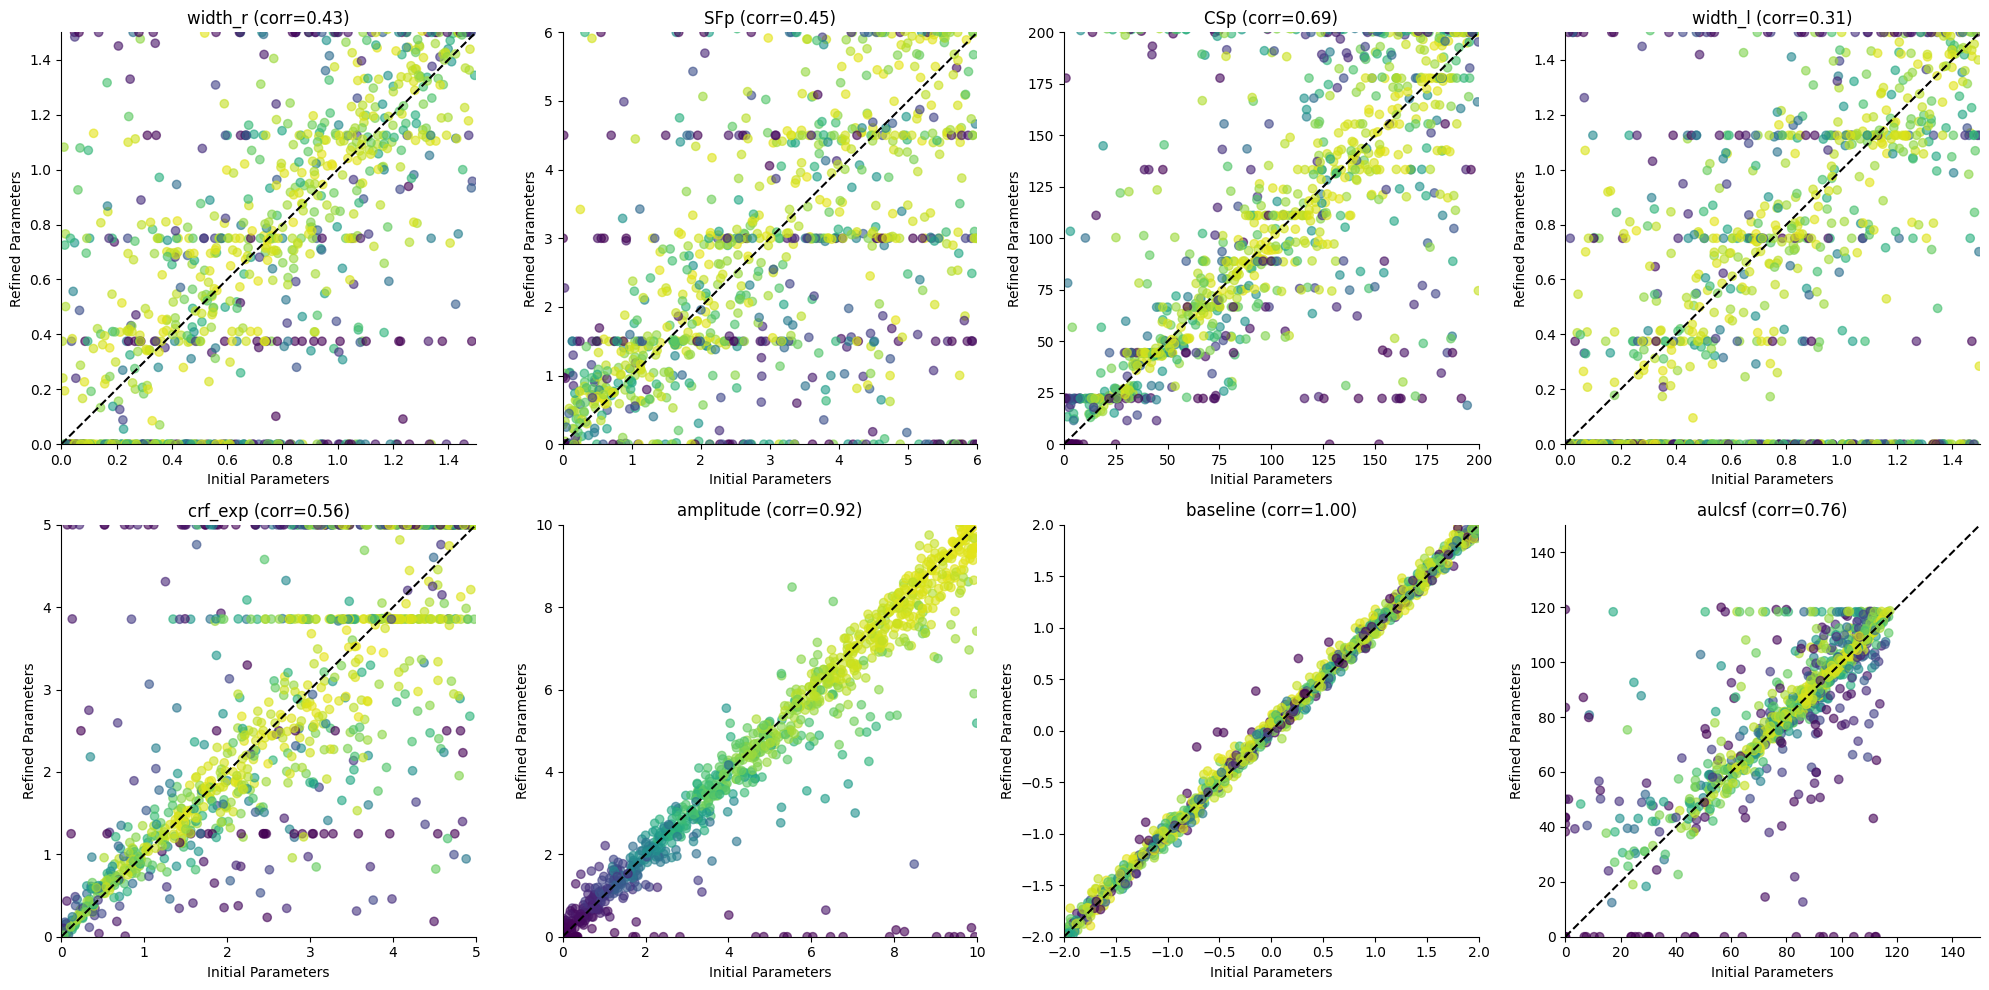

In [32]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
param_names = parameters.columns
rsq = cfitter.get_rsq(parameters=refined_pars)
for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(
        parameters[param], 
        refined_pars[param], 
        c=rsq, 
        alpha=0.6,
        # cmap='viridis',
        vmin=0, vmax=1,
        )
    corr = np.corrcoef(parameters[param], refined_pars[param])[0, 1]
    ax.set_title(f'{param} (corr={corr:.2f})')
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
    # ax.set_aspect('square')
    sns.despine()

plt.tight_layout()
plt.show()

dict_keys(['log_prob', 'diverging', 'is_accepted', 'accept_ratio', 'leapfrogs_taken', 'step_size', 'elapsed_time'])


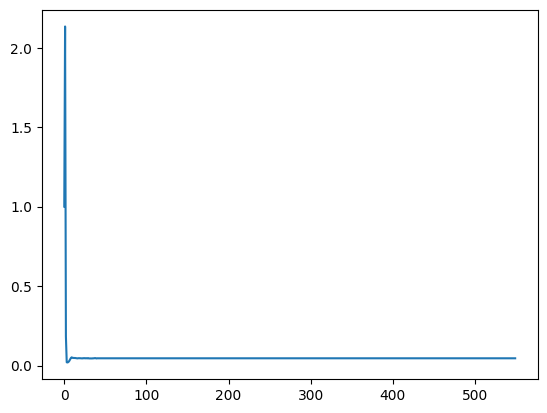

In [33]:
print(bfitter.mcmc_stats.keys())
plt.plot(bfitter.mcmc_stats['step_size'].numpy())



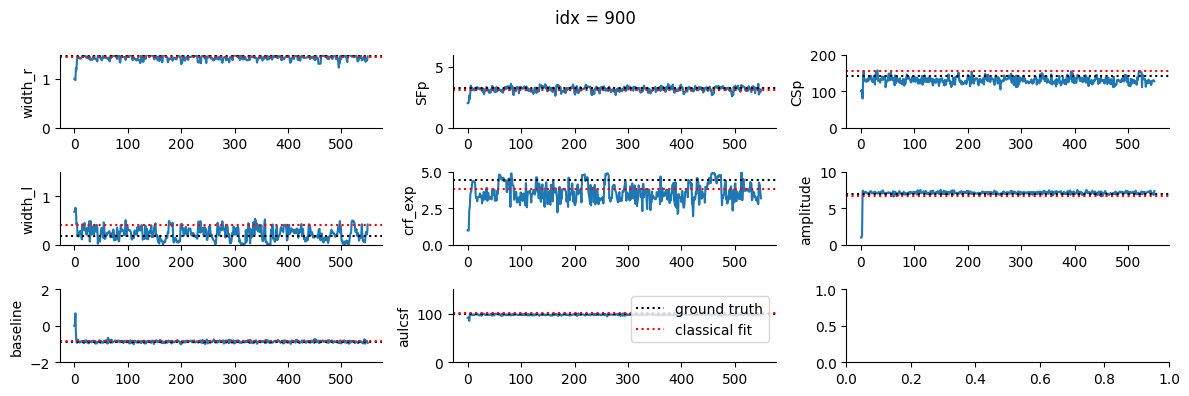

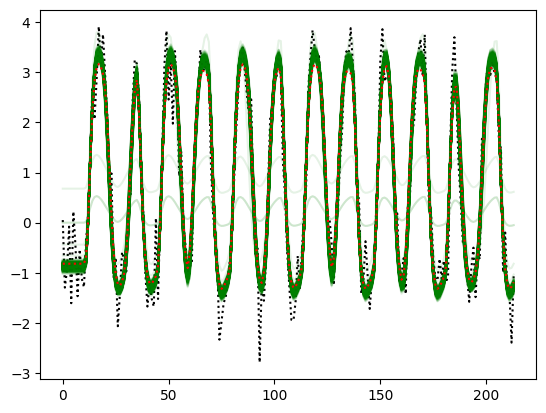

In [45]:
idx = 900
fig, axs = plt.subplots(3,3, figsize=(12,4))
fig.suptitle(f'idx = {idx}')
axs = axs.flatten()
for i,p in enumerate(list(bfitter.model_labels.keys()) + ['aulcsf']):    
    axs[i].plot(
        bfitter.mcmc_sampler[idx][p]
    )
    axs[i].axhline(parameters[p][idx], linestyle=':', color='k', label='ground truth')
    axs[i].axhline(refined_pars[p][idx] , linestyle=':', color='r', label='classical fit')
    axs[i].set_ylabel(p)
    axs[i].set_ylim(bounds[p])
    sns.despine()

axs[i].legend()
fig.set_tight_layout('tight')
plt.figure()
plt.plot(data.iloc[:,idx], ':k')
preds = bfitter.get_predictions(parameters=bfitter.mcmc_sampler[idx])
plt.plot(preds, alpha=0.1, color='g')
cpreds = model.predict(parameters=refined_pars)
plt.plot(cpreds.iloc[:,idx], ':r')

/tmp/ipykernel_1845319/405415224.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


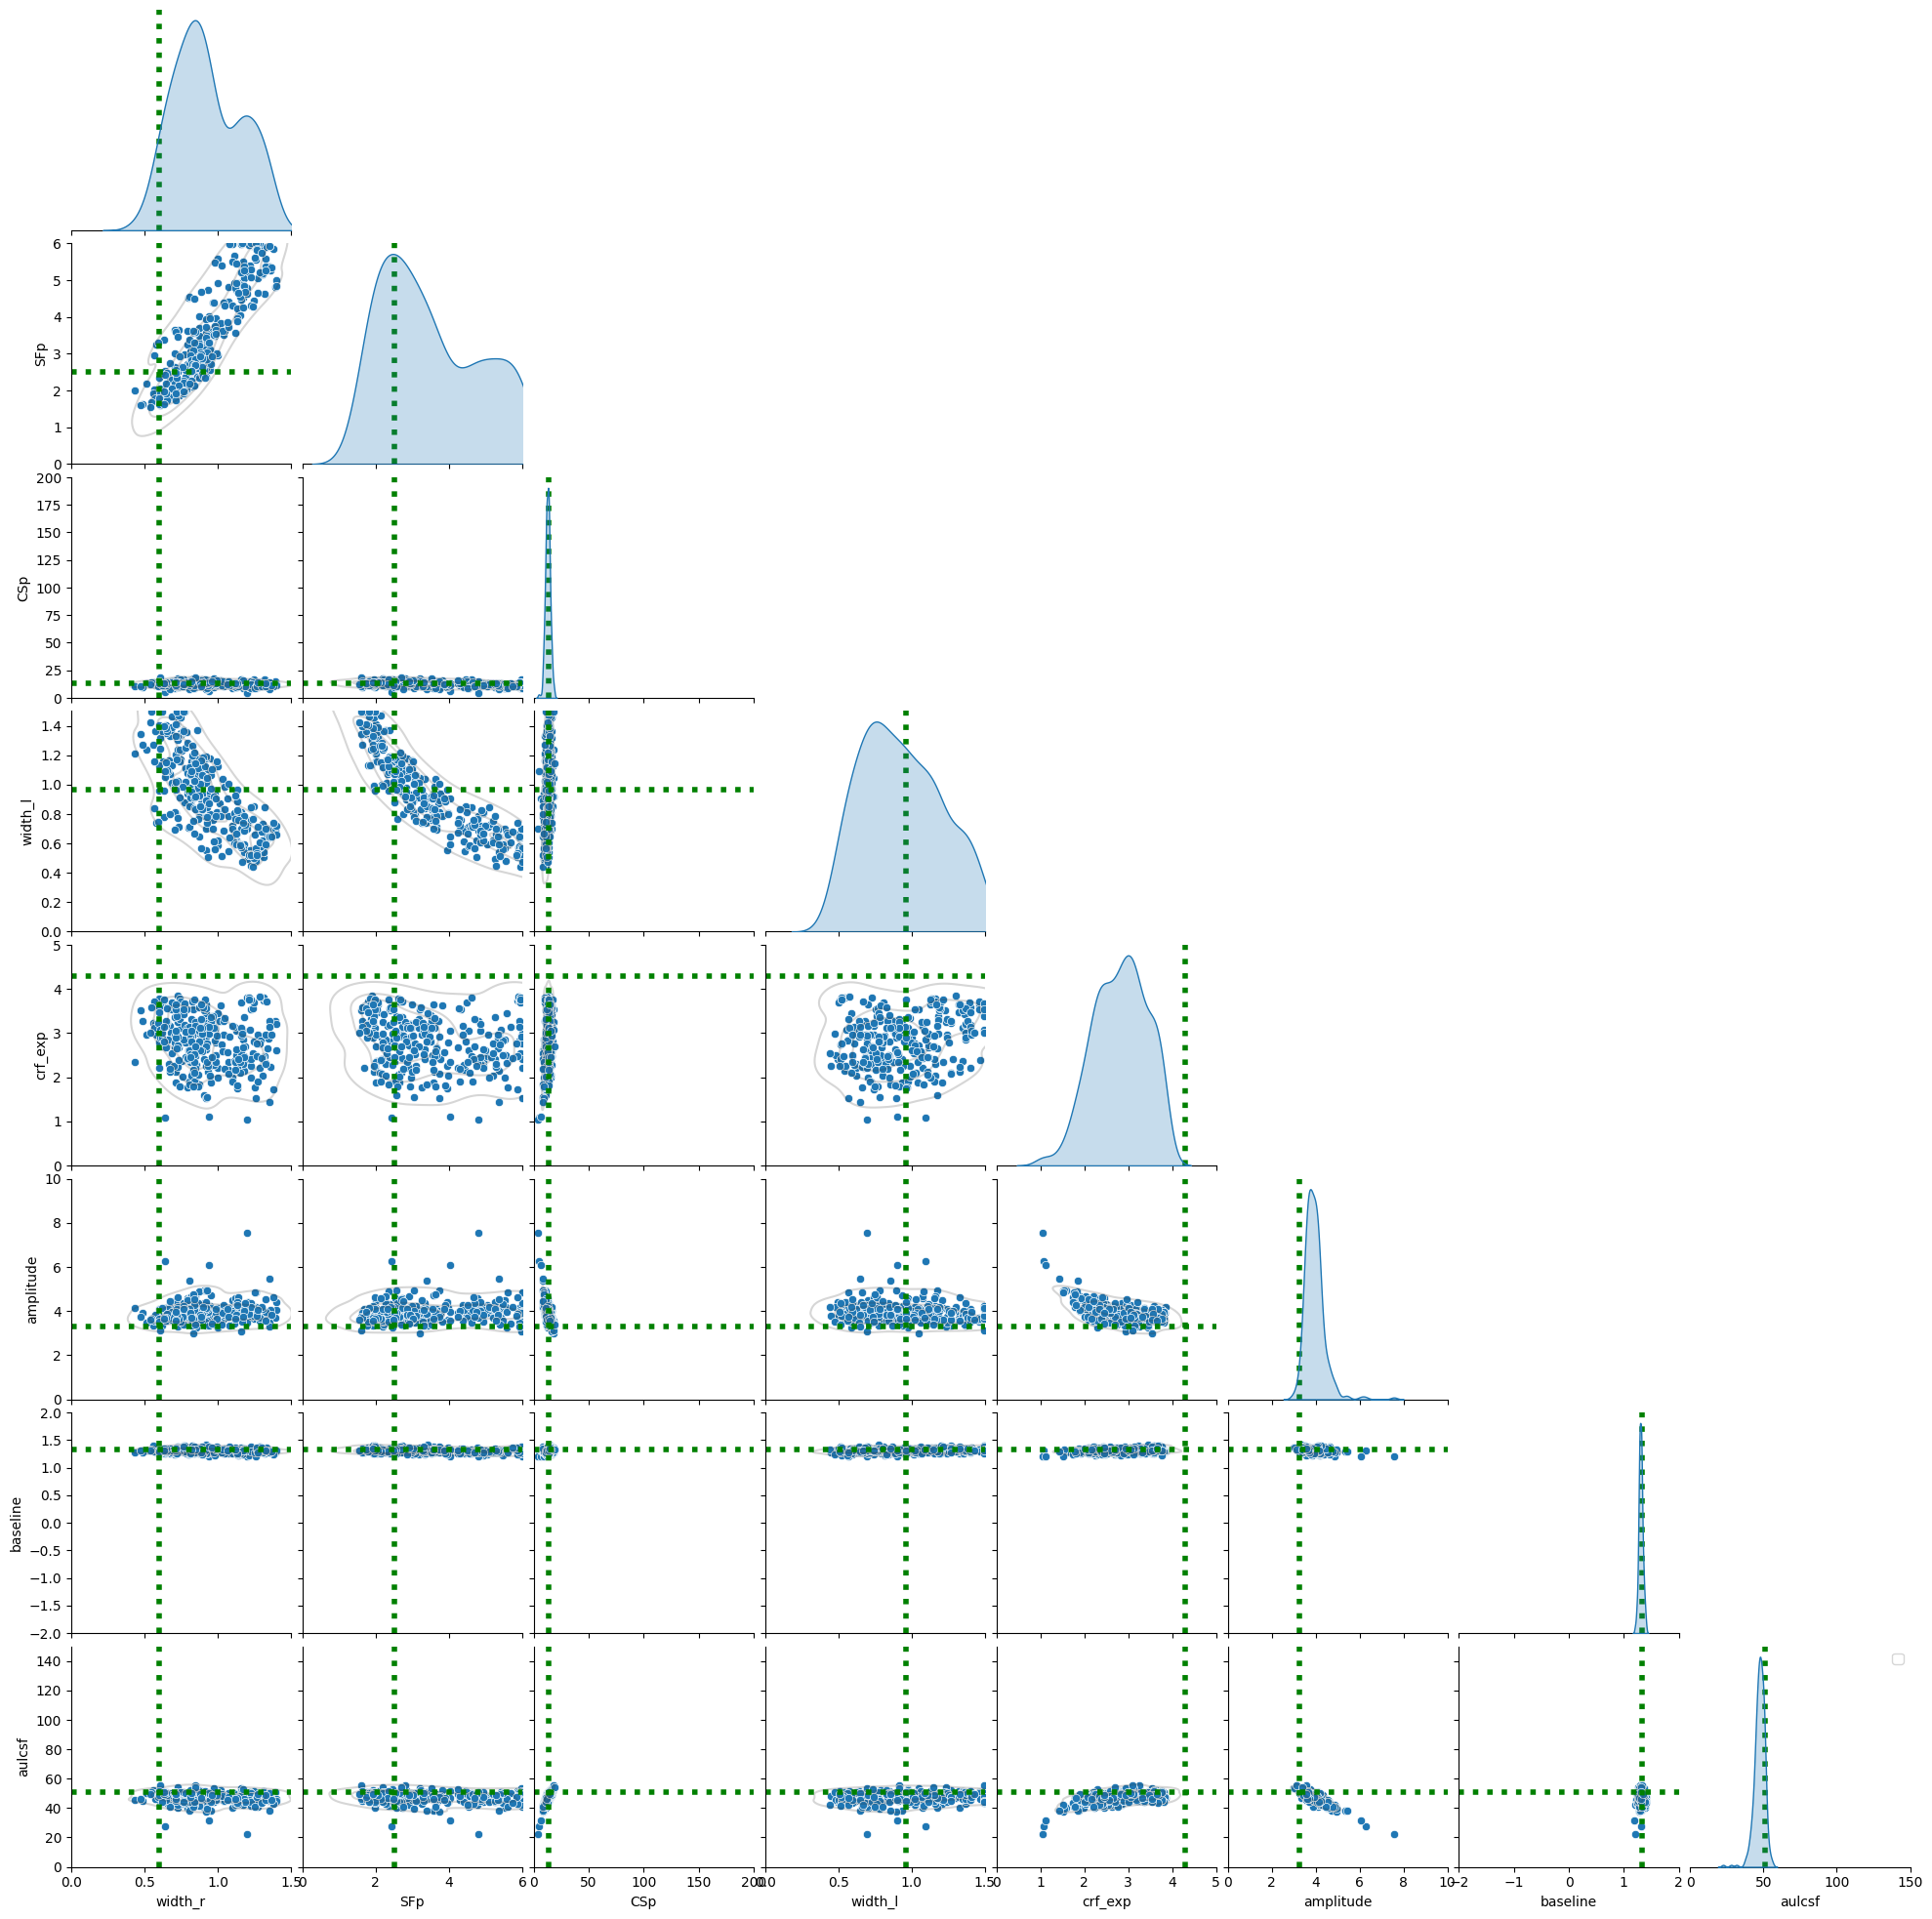

In [46]:
idx = 0
burn_in = 250
this_mcmc_pars = bfitter.mcmc_sampler[idx].iloc[burn_in:,:]
rsq = bfitter.get_rsq_for_idx(idx=idx, parameters=this_mcmc_pars)
# bloop
sns_plot = sns.pairplot(
    this_mcmc_pars,
    # plot_kws={'color':rsq_cols[burn_in:,:]},
    corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [47]:
data.shape

(214, 1000)

In [ ]:
bfitter.mcmc_sampler[idx]

In [ ]:
this_mcmc_pars